## Imports

In [1]:
import numpy as np
from numpy import pi, cos, sin, array, exp, sqrt, log10
from numpy.random import randn

In [2]:
from scipy import signal, interpolate

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
np.set_printoptions(precision=3, suppress=True)

In [4]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

# Modulation model

#### Symbol mapping

In [5]:
class Mapper:
    
    def __init__(self):
        self.BPSK_LUT = array([-1 -1j, 1 + 1j])/np.sqrt(2)
        self.QPSK_LUT = array([-1-1j, -1+1j, 1-1j, 1+1j])/np.sqrt(2)
        self.PSK8_LUT = array([exp(3j*pi/4), -1, 1j, exp(1j*pi/4), 
                               -1j, exp(-3j*pi/4), exp(-1j*pi/4), 1])
        # The scaling factor for 16QAM is sqrt(10), 
        # since avg_power = [4*2 + 8*10 + 4*18]/16 = 10
        # Also the LUT for 16QAM in the book matlab code has an error
        self.QAM16_LUT = array([-3-3j, -3-1j, -3+3j, -3+1j,
                                -1-3j, -1-1j, -1+3j, -1+1j,
                                 3-3j, 3-1j, 3+3j, 3+1j,
                                 1-3j, 1-1j, 1+3j, 1+1j])/np.sqrt(10)
        
    def convert_bit_array_to_int(self, array_of_bits):
        '''
        >>> convert_bit_array_to_int(  np.array([0, 1, 1, 0]) )
        6
        '''
        bit_str = np.array2string(array_of_bits, separator='')[1:-1] #Sliced to remove brackets
        return int(bit_str, 2)
    
    
    def convert_to_symbols(self, bitstream, bits_in_symbol, LUT):
        num_symbols = len(bitstream)//bits_in_symbol
        truncated_bitstream = bitstream[:num_symbols*bits_in_symbol]
        
        if len(truncated_bitstream) != len(bitstream):
            print(f'Truncating {len(bitstream) - len(truncated_bitstream)} bits at the end.')
        
        symbol_bits = np.split(truncated_bitstream, num_symbols) # list of sub-arrays
        symbols = array( [LUT[self.convert_bit_array_to_int(bits)]
                          for bits in symbol_bits] )
        return symbols
        
        
    def bpsk(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=1, LUT=self.BPSK_LUT)
    
    def qpsk(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=2, LUT=self.QPSK_LUT)
    
    def psk8(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=3, LUT=self.PSK8_LUT)
    
    def qam16(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=4, LUT=self.QAM16_LUT)
    
    
# Create a modulator
mapper = Mapper()

In [6]:
random_bits = np.random.choice([0, 1], 10)
print('Bits: {}'.format(random_bits))

qpsk = mapper.qpsk(random_bits)
print('QPSK symbols: {}'.format(qpsk*np.sqrt(2)))

Bits: [1 0 0 0 0 1 0 0 1 0]
QPSK symbols: [ 1.-1.j -1.-1.j -1.+1.j -1.-1.j  1.-1.j]


#### Waveform 

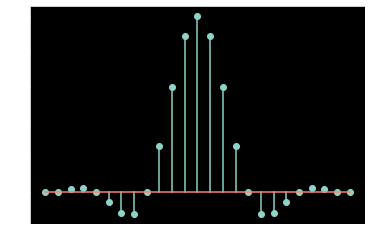

In [7]:
def rcosine(osr, β):
    # All calculations are normalized by T
    duration = (-3, 3)
    N = osr*(duration[1] - duration[0]) + 1
    t = np.linspace(*duration, N)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore') # For Divide by zero
        rcos_filt = np.sinc(t) * cos(pi*β*t) / (1-(2*β*t)**2)
    rcos_filt[np.isinf(rcos_filt)] = (pi/4)*np.sinc(1/(2*β))
    delay = duration[1]*osr # Delay of impulse peak in samples
    return rcos_filt, delay

plt.stem(rcosine(4, 0.5)[0]);

In [8]:
def zero_stuff(symbols, osr):
    num_symbols = len(symbols)
    sample_stream = np.zeros(num_symbols * osr, complex)
    sample_stream[::osr] = symbols
    return sample_stream

def waveform_mapping(symbols, osr=4, beta=0.5):
    sample_stream = zero_stuff(symbols, osr)
    pulse, delay = rcosine(osr, beta)
    output_samples = signal.lfilter(pulse, 1, sample_stream)
    return output_samples, delay

In [9]:
def plot_waveform(waveform, delay, osr):
    idx = np.arange(len(waveform))
    symbol_idx = np.arange(delay, len(waveform), osr)
    
    fig = plt.figure(figsize = (10, 4))
    
    plt.subplot(221)
    plt.plot(idx, waveform.real, symbol_idx, waveform[symbol_idx].real, 'o', fillstyle='none') 

    plt.subplot(223)
    plt.plot(idx, waveform.imag, symbol_idx, waveform[symbol_idx].imag, 'o', fillstyle='none') 

    plt.subplot(122)
    plt.plot(waveform.real, waveform.imag, '-.', waveform[symbol_idx].real, waveform[symbol_idx].imag, '.')
    plt.grid(linestyle='dashed')

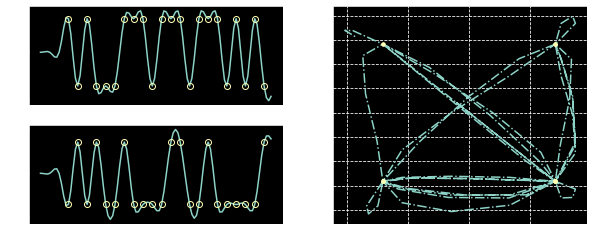

In [10]:
random_bits = np.random.choice([0, 1], 50)
qpsk = mapper.qpsk(random_bits)
sample_stream = zero_stuff(qpsk, 4)
waveform, delay = waveform_mapping(qpsk, 4)

plot_waveform(waveform, delay, 4)

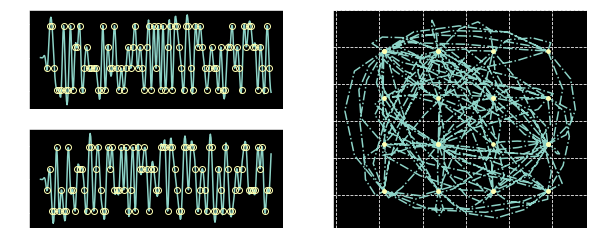

In [11]:
random_bits = np.random.choice([0, 1], 400)
qam16 = mapper.qam16(random_bits)
waveform, delay = waveform_mapping(qam16, 4)

plot_waveform(waveform, delay, 4)

# The Defect Model

### Multipath

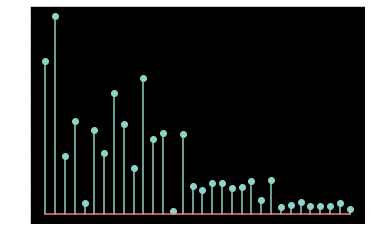

In [12]:
def get_multipath_filter(sample_rate, delay_spread, N):
    Ts = 1/sample_rate # Sampling rate in secs
    T_rms = delay_spread # Delay spread in secs
    var = exp( np.arange(N)*(-Ts/T_rms) )
    
    # Book matlab code has σ^2, instead of 0.5σ^2
    fir = sqrt(var/2)*(np.random.randn(N) + 1j*np.random.randn(N)) 
    return fir

# Mode 100 nsec delay spread over 32 paths, sampled at 40 MHz
delay_spread_model = get_multipath_filter(40e6, 100e-9, 32)
plt.stem(abs(delay_spread_model));

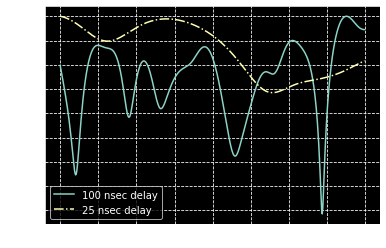

In [13]:
delay_100ns = get_multipath_filter(40e6, 100e-9, 32)
w, h = signal.freqz(delay_100ns)
h_db = 20*np.log10(abs(h))
h_db -= max(h_db)
plt.plot(40*w/pi, h_db, '-', label='100 nsec delay')

delay_25ns = get_multipath_filter(40e6, 25e-9, 32)
w, h = signal.freqz(delay_25ns)
h_db = 20*np.log10(abs(h))
h_db -= max(h_db)
plt.plot(40*w/pi, h_db, '-.', label='25 nsec delay')

plt.grid(linestyle='dashed')
plt.legend();

### Gaussian White Noise

In [14]:
def generate_awgn(signal, snr):
    signal_power = np.dot(signal, signal.conj())/len(signal)
    noise_power = signal_power/(10**(snr/10))
    noise_var = sqrt(noise_power) 
    noise = (noise_var/sqrt(2))*( randn(len(signal)) + 1j*randn(len(signal)) )
    return noise

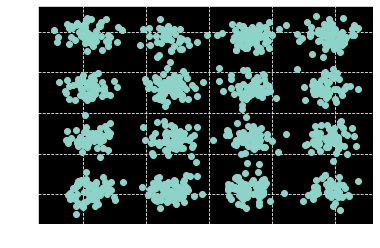

In [15]:
random_bits = np.random.choice([0, 1], 4000)
symbols = mapper.qam16(random_bits)

awgn = generate_awgn(symbols, 17)
signal_with_noise = symbols + awgn

plt.plot(signal_with_noise.real, signal_with_noise.imag, 'o');
plt.grid(linestyle='dashed');


### Phase Noise (Incomplete)

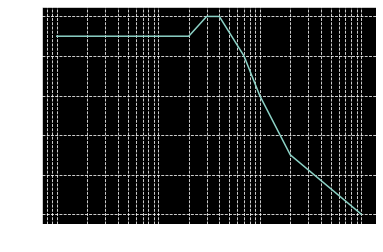

In [16]:
freq = array([1e3, 20e3, 30e3, 40e3, 70e3, 100e3, 200e3, 1000e3])
dbc = array([-85, -85, -80, -80, -90, -100, -115, -130])

plt.semilogx(freq, dbc)
plt.grid(ls='--', which='both');

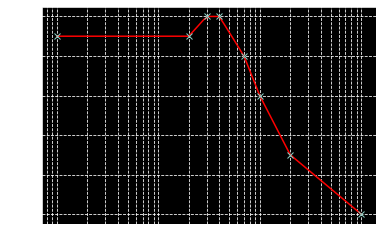

In [17]:
freq_db = 20*log10(freq)
new_freqs_db = np.arange(20*log10(1e3), 1+20*log10(1e6))

f = interpolate.interp1d(freq_db, dbc, fill_value = 'extrapolate')
new_dbc = f(new_freqs_db)

plt.semilogx(10**(new_freqs_db/20), new_dbc, 'r', freq, dbc, 'x');
plt.grid(ls='--', which='both')

### IQ Imbalance

In [18]:
def iq_imbalance(samples, iq_phase_error, i_gain, q_gain):
    I = samples.real
    Q = samples.imag
    
    # Phase imbalance model
    I_temp = I + Q*sin(iq_phase_error)
    Q_temp = Q*cos(iq_phase_error)
    
    # Gain imbalance model
    I_out = i_gain * I_temp
    Q_out = q_gain * Q_temp
    
    return I_out + 1j*Q_out

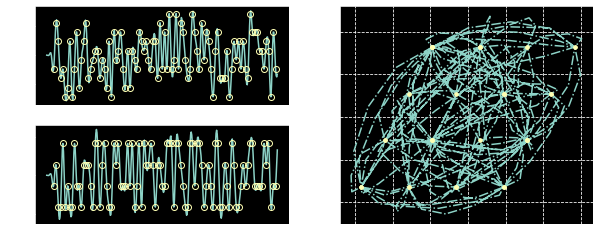

In [19]:
random_bits = np.random.choice([0, 1], 4000)
symbols = mapper.qam16(random_bits)
waveform, delay = waveform_mapping(qam16, 4)

distorted_samples = iq_imbalance(waveform, pi/6, 10, 1)
plot_waveform(distorted_samples, delay, 4)

# Testbench

### Configurable parameters

In [20]:
# Ideal tx params
num_bits = 400
symbol_rate = 10e6 # 10 Msps
osr = 4
modulation = 'qam16'

In [21]:
# Multipath params
enable_multipath = False
delay_spread = 50e-9
delay_taps = 40
sample_rate = osr * symbol_rate

# AWGN
enable_awgn = False
snr_db = 10

# Frequency offset 
enable_freq_offset = False
freq_offset = -100e3

# IQ Imbalance
enable_iq_imbalance = True
phase_imbalance = pi/12 # radians
amplitude_imbalance_db = 3 # dB

### Run Testbench

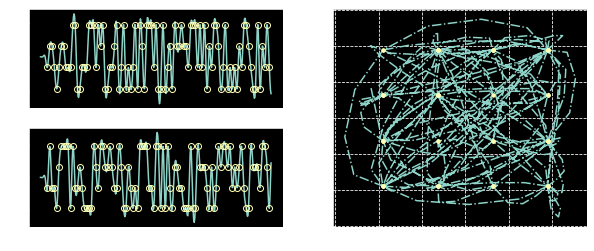

In [22]:
mapper = Mapper()
modulator = getattr(mapper, modulation)

tx_bits = np.random.choice([0, 1], num_bits)
tx_symbols = modulator(tx_bits)
tx_samples, delay = waveform_mapping(tx_symbols, osr=osr)

plot_waveform(tx_samples, delay, osr)

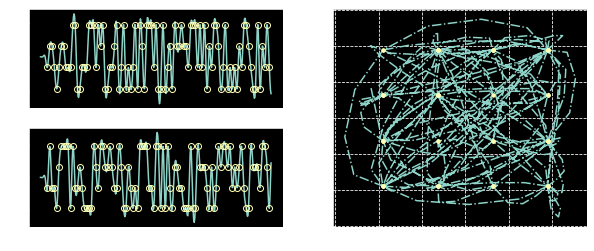

In [23]:
multipath_filter = get_multipath_filter(sample_rate, delay_spread, delay_taps)
if enable_multipath:
    print('Multipath enabled')
    tx_samples = signal.lfilter(multipath_filter, 1, tx_samples)
    output_var = np.var(tx_samples)
    tx_samples /= np.sqrt(output_var)

plot_waveform(tx_samples, delay, osr)

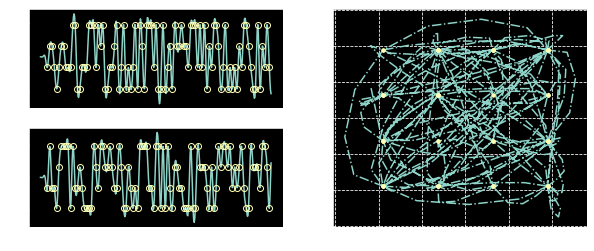

In [24]:
if enable_awgn:
    print(f'Adding AWGN, SNR = {snr_db} dB')
    tx_samples = tx_samples + generate_awgn(tx_samples, snr_db)
    
plot_waveform(tx_samples, delay, osr)

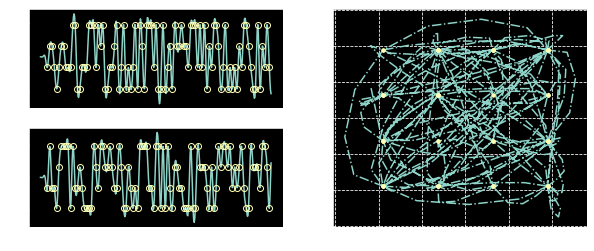

In [25]:
if enable_freq_offset:
    print(f'Freq offset : {freq_offset/1e3} KHz')
    n = np.arange(len(tx_samples))
    freq_offset_signal = exp(2j*pi*freq_offset*n/sample_rate)
    tx_samples = tx_samples * freq_offset_signal
    
plot_waveform(tx_samples, delay, osr)

IQ imbalance:
	 phase = 0.2618 radians
	 amplitude = 3 dB


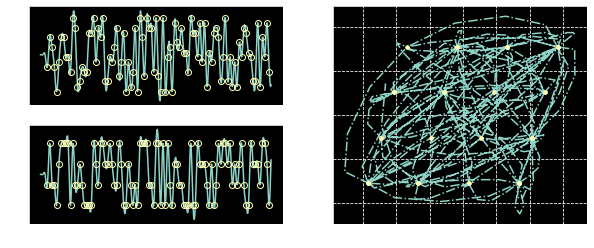

In [26]:
if enable_iq_imbalance:
    print(f'IQ imbalance:\n\t phase = {phase_imbalance:.4f} radians\n\t amplitude = {amplitude_imbalance_db} dB')
    i_gain = 10**(0.5*amplitude_imbalance_db/20)
    q_gain = 10**(-0.5*amplitude_imbalance_db/20)
    tx_samples = iq_imbalance(tx_samples, phase_imbalance, i_gain, q_gain)
    
plot_waveform(tx_samples, delay, osr)